# Lab 8 : Decision Trees


# 1. Load the dataset (X and Y vector)

In [6]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns 

DATASET_PATH = '../data/Fish_Dataset/Fish_Dataset/'

In [7]:
def get_labels():
    folders = os.listdir(DATASET_PATH)
    labels = []
    for f in folders:
        if not('.m' in f) and not('.txt' in f):
            labels.append(f)
    labels = np.array(labels)
    return labels

def get_X_Y(labels):
    # Get the images for each label
    img_shape = (128, 128) #resizing images to this shape ( after converting color image to gray image)
    n_sample_per_class = 600 #Keep only this number of samples per class (expensive complexity issue)
    nb_img = n_sample_per_class*len(labels) #1000 images per class

    X = np.zeros((nb_img, img_shape[0]*img_shape[1])) # feature matrix
    Y = np.zeros(nb_img) #labels vector
    for i in range(len(labels)):
        folder = os.path.join(DATASET_PATH, labels[i], labels[i])
        images = os.listdir(folder)
        np.random.shuffle(images)
        for j in range(n_sample_per_class):
            img_path = os.path.join(folder, images[j])
            img = cv2.imread(img_path, 0) #Load the gray image
            #Resizing
            img = cv2.resize(src=img, dsize=img_shape)
            #Normalization
            img = img/255
            #Add the image in the feature matrix and its labels to the label vector
            X[i*n_sample_per_class+j, :] = img.flatten()
            Y[i*n_sample_per_class+j] = np.argwhere(labels==labels[i])[0]
    return X, Y

labels = get_labels()
X, Y = get_X_Y(labels)
print("Feature matrix : \n", X)
print("Label vector : \n", Y)

pca = PCA(n_components=10)
pca.fit(X)
X = pca.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

Feature matrix : 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Label vector : 
 [0. 0. 0. ... 8. 8. 8.]


# 2. Hyperparameter Experimentation

## 2.1 Pipelines

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression

lin_pipe = Pipeline(steps=[('lin', LinearRegression())])
lin_params_grid = {
    #'lin__fit_intercept' : [True, False]
}

log_pipe = Pipeline(steps=[('log', LogisticRegression(random_state=42))])
log_params_grid = {
    # 'log__fit_intercept' : [True, False]
    #'log__max_iter' : [100, 200]
    # 'log__solver' : ['lbfgs', 'sag']
}

# 2.2 SearchCV Algorithms

In [9]:
def search_cv(name, est, grid, search):
    search = search(est, grid)
    search.fit(X_train, y_train)
    search.score(X_train, y_train)
        
    print(f"Best params found for {name} with {str(search)}: ", search.best_params_)
:
    print("Score : ", round(search.score(X_test, y_test), 3)) 

    return search


In [10]:
lin_grid = search_cv('Linear Regression', lin_pipe, lin_params_grid, GridSearchCV)
#lin_rand = search_cv('Linear Regression', lin_pipe, lin_params_grid, RandomizedSearchCV)
log_grid = search_cv('Logistic Regression', log_pipe, log_params_grid, GridSearchCV)
#log_rand = search_cv('Logistic Regression', log_pipe, log_params_grid, RandomizedSearchCV)

Best params found for Linear Regression with GridSearchCV(estimator=Pipeline(steps=[('lin', LinearRegression())]),
             param_grid={}):  {}


ValueError: X has 10 features, but LinearRegression is expecting 16384 features as input.

# 3. Cross Validation & Train-Test Splits

<BarContainer object of 4 artists>

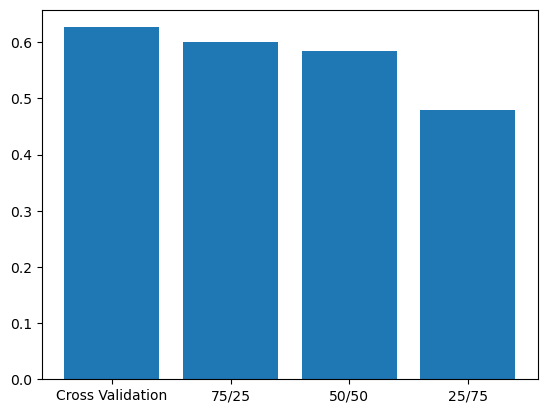

In [ ]:
criterion = 'entropy'
max_depth = 14

tree_model = DecisionTreeClassifier(max_depth=max_depth, criterion=criterion, random_state=42)

# use whole dataset for cross validation
scores = [cross_val_score(tree_model, X, Y, cv=10).mean()]

# Compute the accuracy for each dataset splits
x_tests = [X_test_a, X_test_b, X_test_c]
x_trains = [X_train_a, X_train_b, X_train_c]
y_tests = [y_test_a, y_test_b, y_test_c]
y_trains = [y_train_a, y_train_b, y_train_c]

for x_test, y_test, x_train, y_train in zip (x_tests, y_tests, x_trains, y_trains):
    prediction = test_tree(max_depth, x_train, y_train, x_test, criterion)
    scores.append(len(np.where(prediction==y_test)[0]) / len(prediction))

labels = ['Cross Validation', '75/25', '50/50', '25/75']

plt.bar(labels, scores)


# 5. Metrics

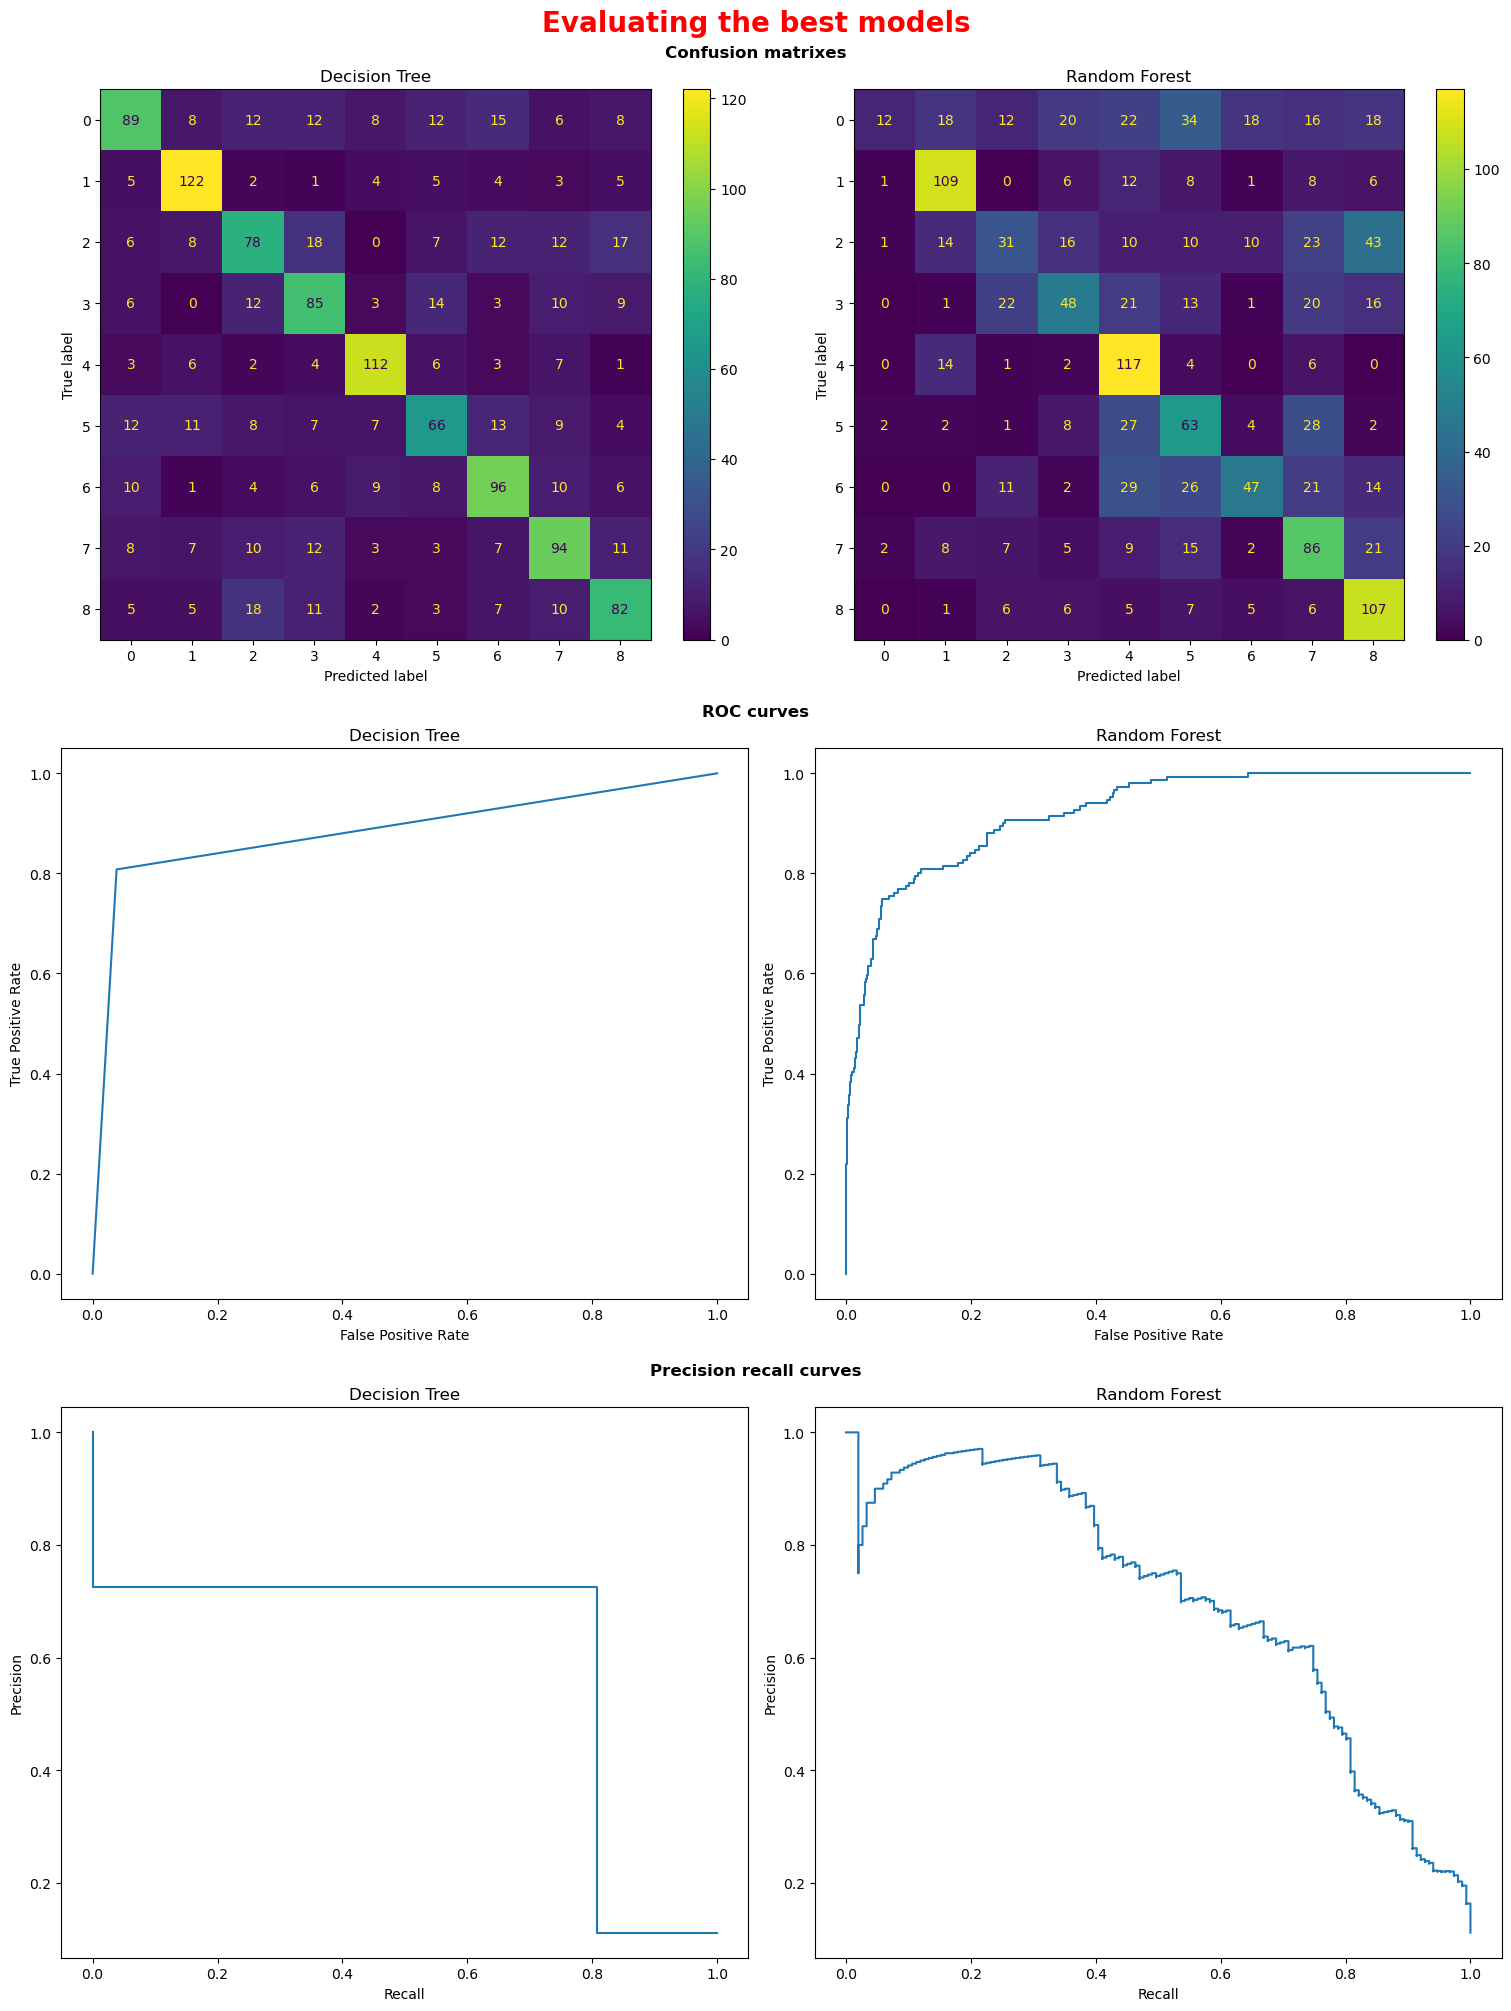

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

model_names = ["Decision Tree", "Random Forest"]
model_list = [(dt_params_grid, dt_grid_search, "Decision Tree"), (rf_params_grid, rf_search, "Random Forest")]
grid_tuples = []
for grid in grids:
    grid_tuples.append((grid, grid.predict(X_test_a), grid.predict_proba(X_test_a)))


def plot_confusion_matrixes(axs, grid_tuples):
    for i, grid_tuple in enumerate(grid_tuples):
        cm = confusion_matrix(y_test_a, grid_tuple[1])
        cm_display = ConfusionMatrixDisplay(cm)
        cm_display.plot(ax=axs[i]) 
        cm_display.ax_.set_title(model_names[grids.index(grid_tuple[0])])

def plot_roc_curves(axs, grid_tuples):
    for i, grid_tuple in enumerate(grid_tuples):
        fpr, tpr, thresholds = roc_curve(y_test_a, grid_tuple[2][:, 1], pos_label=1)
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
        roc_display.plot(ax=axs[i]) 
        roc_display.ax_.set_title(model_names[grids.index(grid_tuple[0])])

def plot_precision_recall_curves(axs, grid_tuples):
    for i, grid_tuple in enumerate(grid_tuples):
        prec, recall, thresholds = precision_recall_curve(y_test_a, grid_tuple[2][:, 1], pos_label=1)
        pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)
        pr_display.plot(ax=axs[i]) 
        pr_display.ax_.set_title(model_names[grids.index(grid_tuple[0])])


subfigures_titles = ['Confusion matrixes', 'ROC curves', 'Precision recall curves']
subplot_funcs = [plot_confusion_matrixes, plot_roc_curves, plot_precision_recall_curves]


fig = plt.figure(constrained_layout=True, figsize=(15, 20))
fig.suptitle('Evaluating the best models', fontweight='bold', size=20, color='red')

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=3, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(subfigures_titles[row], fontweight='semibold')

    # create 1x2 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=2)
    subplot_funcs[row](axs, grid_tuples)